# WarpAffine

This is a notebook is a usage example for WarpAffine transform.

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import math
import os

test_data_root = os.environ['DALI_EXTRA_PATH']
db_folder = os.path.join(test_data_root, 'db', 'lmdb')

def gen_transform(angle, zoom, dst_cx, dst_cy, src_cx, src_cy):
    t1 = np.array([[1, 0, -dst_cx], [0, 1, -dst_cy], [0, 0, 1]])
    def u():
        return np.random.uniform(-0.5, 0.5)
    r = np.array([
        [1 + u(), u(), 0],
        [u(), 1 + u(), 0],
        [0, 0, 1]])
    t2 = np.array([[1, 0, src_cx], [0, 1, src_cy], [0, 0, 1]])
    return (np.matmul(t2, np.matmul(r, t1)))[0:2,0:3]

def gen_transforms(n, step):
    a = 0.0
    step = step * (math.pi/180)
    out = np.zeros([n, 2, 3])
    for i in range(n):
        out[i,:,:] = gen_transform(a, 2, 200, 200, 100, 100)
        a = a + step
    return out.astype(np.float32)

class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, pipelined = True, exec_async = True):
        super(HybridPipe, self).__init__(batch_size, num_threads, device_id, seed = 12, exec_pipelined=pipelined, exec_async=exec_async)
        self.input = ops.CaffeReader(path = db_folder, random_shuffle = True)
        self.decode = ops.ImageDecoder(device = "cpu", output_type = types.RGB)
        
        # not specifying `fill_value` results in source coordinate clamping
        self.warp_gpu = ops.WarpAffine(device = "gpu", size = (400,400), interp_type = types.INTERP_LINEAR)
        self.warp_cpu = ops.WarpAffine(device = "cpu", fill_value = 200, size = (400,400), interp_type = types.INTERP_NN)
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.transform_source = ops.ExternalSource()
        self.iter = 0

    def define_graph(self):
        self.transform = self.transform_source()
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        outputs = [images.gpu()]
        # pass the transform parameters through GPU memory
        outputs += [self.warp_gpu(images.gpu(), self.transform.gpu())]
        # pass the transform through a named input
        outputs += [self.warp_cpu(images, matrix = self.transform).gpu()]

        return [self.labels] + outputs

    def iter_setup(self):
        self.feed_input(self.transform, gen_transforms(self.batch_size, 10))


In [2]:
batch_size = 32

np.random.seed(seed = 123)
pipe = HybridPipe(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

In [3]:
pipe_out = pipe.run()

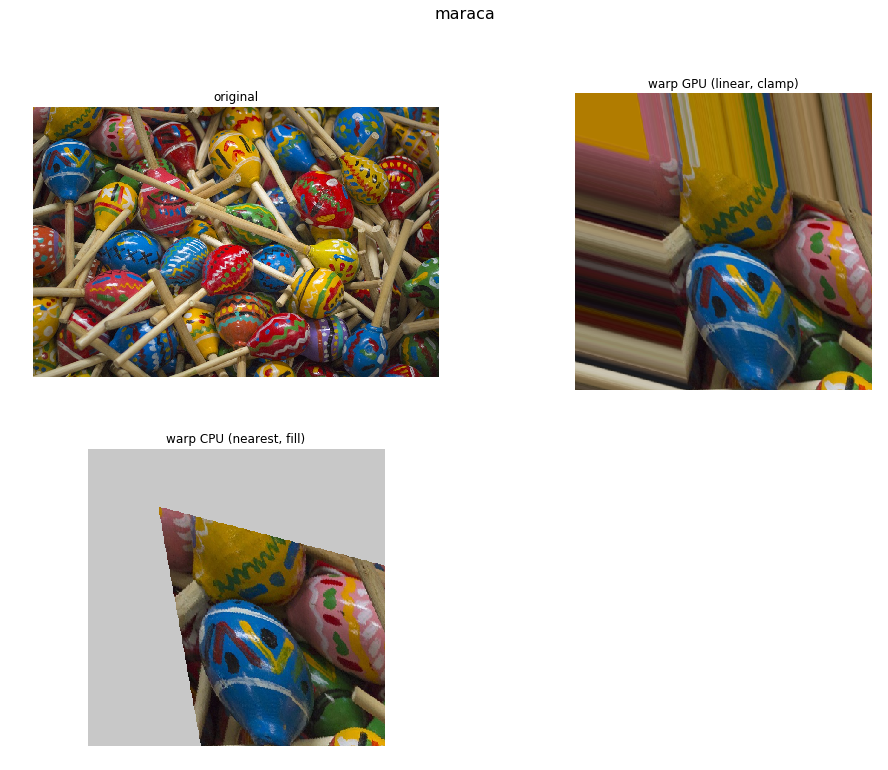

In [4]:
n = 0
from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec
len_outputs = len(pipe_out) - 1
augmentations = ["original", "warp GPU (linear, clamp)", "warp CPU (nearest, fill)"]
fig = plt.figure(figsize = (16,12))
plt.suptitle(imagenet_synsets[pipe_out[0].at(n)[0]], fontsize=16)
columns = 2
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[1 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow((img_chw)/255.0)